In [1]:
import json
import pandas as pd

In [2]:
fileformat = '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-{}-deduped/ids_dataset_{}_step_{}.json' # size dataset step
file14m = '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-14m/ids_dataset_{}_step_143000.json' # size
pileformat_pythia = '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-{}-deduped/ids_dataset_pile_step_None{}.json' # size shuffled
fileformat_lengths = '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-{}-deduped/ids_dataset_{}_step_143000_length_{}.json' # size ds lengths
fileformat_14m_lengths = '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-14m/ids_dataset_{}_step_143000_length_{}.json' # size ds lengths
llama_mistral_format = '/home/echeng/llm_compositionality/results_new/{}/ids_dataset_{}.json' # model, k
llama_mistral_length_format = '/home/echeng/llm_compositionality/results_new/{}/ids_dataset_{}_length_{}.json' # model, k, l

In [21]:
SIZES = ['14m', '70m', '160m', '2.8b', '12b']
LENGTHS = [3, 6, 9, 11]
CKPTS = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 
         1000, 2000, 3000, 4000, 8000, 13000, 23000 ,32000, 33000, 43000,
         53000, 63000, 64000, 73000, 83000, 93000, 103000, 113000, 123000, 133000,
         143000]
SCALING_SIZES = ['410m', '1.4b', '6.9b']
OTHER_MODELS = ['llama', 'mistral']
DATASETS = [1, 2, 3, 4, 'pile', 'pile_shuffled']
DATASET_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


HIDDEN_DIMS = {
    '14m': 128, 
    '70m': 512, 
    '160m': 768, 
    '410m': 1024,
    '1.4b': 2048,
    # '2.8b': 2560, 
    '6.9b': 4096,
    '12b': 5120,
    'llama': 4096,
    'mistral': 4096
}

MODES = ['sane', 'shuffled']

In [4]:
def load_data(size, dataset, step=None, l=None):
    if l is not None and size == '14m':
        filepath = fileformat_14m_lengths.format(dataset, l)
    elif l is not None and size not in OTHER_MODELS:
        filepath = fileformat_lengths.format(size, dataset, l)
    elif size in OTHER_MODELS and l is None:
        filepath = llama_mistral_format.format(size, dataset) 
    elif size in OTHER_MODELS and l is not None:
        filepath = llama_mistral_length_format.format(size, dataset, l) 
    else:
        if dataset == 'pile':
            filepath = pileformat_pythia.format(size, '')
        elif dataset == 'pile_shuffled':
            filepath = pileformat_pythia.format(size, '_shuffled')
        else:
            filepath = fileformat.format(size, dataset, step) if size != '14m' else file14m.format(dataset, 143000)
    with open(filepath , 'r') as f:
        data = json.load(f)

    return data

In [5]:
RESULTS = []
for model in HIDDEN_DIMS:
    for ds in DATASETS:
        # if model == '14m' and ds == 'pile': continue        
        if model in SCALING_SIZES or ds == 'pile': 
            steps = CKPTS
        elif model in OTHER_MODELS:
            steps = [None]
        else:
            steps = [143000]
            
        for step in steps:
            try:
                results = load_data(model, ds, step)
            except FileNotFoundError:
                continue
                
            if ds not in ('pile', 'pile_shuffled'):
                for mode in MODES:
                    results_ = pd.DataFrame(results[mode])
                    results_['mode'] = mode
                    results_['words_coupled'] = ds
                    results_['step'] = step
                    results_['D'] = HIDDEN_DIMS[model]
                    results_['model'] = model
                    results_['layer'] = list(range(len(results_)))
                    RESULTS.append(results_)
            elif ds == 'pile':
                results_ = pd.DataFrame(results)
                results_['mode'] = 'sane'
                results_['words_coupled'] = 'pile'
                results_['step'] = step
                results_['D'] = HIDDEN_DIMS[model]
                results_['model'] = model
                results_['layer'] = list(range(len(results_)))
                RESULTS.append(results_)
            elif ds == 'pile_shuffled':
                results_ = pd.DataFrame(results)
                results_['mode'] = 'shuffled'
                results_['words_coupled'] = 'pile'
                results_['step'] = step
                results_['D'] = HIDDEN_DIMS[model]
                results_['model'] = model
                results_['layer'] = list(range(len(results_)))
                RESULTS.append(results_)
                
results_df = pd.concat(RESULTS)

In [6]:
results_df[results_df['model']=='mistral']

,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,1120.4,4.758151,15.198693,0.131585,22.025659,0.280357,20.504849,0.087000,sane,1,None,4096,mistral,0
1,1091.4,4.029888,31.813633,0.859284,24.565176,0.196102,22.306148,0.051015,sane,1,None,4096,mistral,1
2,1877.8,3.124100,48.937909,1.292844,19.505332,0.167100,21.621336,0.034521,sane,1,None,4096,mistral,2
3,1981.8,1.166190,69.005771,0.638139,18.851855,0.244806,22.438287,0.045732,sane,1,None,4096,mistral,3
4,2321.0,1.673320,65.374380,0.413680,26.282478,0.278692,25.089678,0.058499,sane,1,None,4096,mistral,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3443.8,1.326650,155.593823,2.061790,24.068646,0.297466,38.596120,0.344961,shuffled,pile,None,4096,mistral,27
28,3442.8,1.600000,144.065501,2.102089,24.989092,0.267711,39.185810,0.335250,shuffled,pile,None,4096,mistral,28
29,3418.6,1.356466,125.037284,1.484350,26.157787,0.235098,37.479734,0.224445,shuffled,pile,None,4096,mistral,29
30,3399.0,1.414214,94.364247,1.265421,26.713002,0.306611,36.592757,0.222325,shuffled,pile,None,4096,mistral,30


In [32]:
results_df['length'] = 17

In [33]:
LENGTH_RESULTS = []
for model in list(HIDDEN_DIMS.keys()):
    for ds in DATASETS:
        if ds == 'pile' or ds == 'pile_shuffled': continue    
        st = 143000 if model not in OTHER_MODELS else None
        for l in LENGTHS:
            try:
                print('here')
                results = load_data(model, ds, 143000, l)
            except FileNotFoundError as e:
                print(e)
                continue
                
            for mode in MODES:
                results_ = pd.DataFrame(results[mode])
                results_['mode'] = mode
                results_['words_coupled'] = int(ds)
                results_['step'] = 143000
                results_['D'] = HIDDEN_DIMS[model]
                results_['model'] = model
                results_['layer'] = list(range(len(results_)))
                results_['length'] = l + 2 if l != 11 else 15
                LENGTH_RESULTS.append(results_)
                
length_results_df = pd.concat(LENGTH_RESULTS)

here
here
here
here
here
[Errno 2] No such file or directory: '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-14m/ids_dataset_2_step_143000_length_3.json'
here
here
here
here
[Errno 2] No such file or directory: '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-14m/ids_dataset_3_step_143000_length_3.json'
here
[Errno 2] No such file or directory: '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-14m/ids_dataset_3_step_143000_length_6.json'
here
here
here
[Errno 2] No such file or directory: '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-14m/ids_dataset_4_step_143000_length_3.json'
here
[Errno 2] No such file or directory: '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-14m/ids_dataset_4_step_143000_length_6.json'
here
here
here
here
here
here
here
[Errno 2] No such file or directory: '/home/echeng/llm_compositionality/results_new/EleutherAI_pythia-70m-deduped/ids_dataset_2_step_143000_length_3.json'
here


In [34]:
results_df = pd.concat([results_df, length_results_df])

In [25]:
results_df = pd.read_csv('emily_id_results_all.csv').drop(columns=['Unnamed: 0'])

In [27]:
results_df = results_df.drop_duplicates()

In [101]:
results_df.to_csv('emily_id_results_all.csv')

In [23]:
length_results_df[length_results_df['model']=='mistral']

,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer,length
0,699.6,5.748043,11.808668,0.143310,9.824352,0.137639,10.747247,0.017198,sane,1,143000,4096,mistral,0,3
1,759.8,7.194442,25.917611,0.893717,10.536608,0.139223,10.807502,0.042098,sane,1,143000,4096,mistral,1,3
2,1423.4,6.183850,31.964801,1.239373,9.572547,0.126816,9.675681,0.038484,sane,1,143000,4096,mistral,2,3
3,1431.6,1.624808,49.070199,0.594676,10.407875,0.089510,10.023509,0.017260,sane,1,143000,4096,mistral,3,3
4,1698.0,1.095445,48.255986,0.510434,11.970922,0.112023,10.998542,0.036502,sane,1,143000,4096,mistral,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,2470.0,3.633180,41.555006,0.655896,16.320007,0.184907,15.869180,0.093476,shuffled,4,143000,4096,mistral,27,11
28,2484.8,3.429286,40.963163,0.605020,16.584400,0.190507,16.283087,0.086591,shuffled,4,143000,4096,mistral,28,11
29,2478.6,3.611094,38.675415,0.547552,16.882685,0.212833,16.798644,0.071543,shuffled,4,143000,4096,mistral,29,11
30,2434.4,3.720215,34.823297,0.353244,16.990809,0.166306,16.966683,0.068516,shuffled,4,143000,4096,mistral,30,11


## Add KC measures to the df

In [35]:
kc_path = '/home/echeng/llm_compositionality/train_test_splits_lengths/kc.txt'
with open(kc_path, 'r') as f:
    kc_data = f.readlines()


kc_results = {'gzip':[], 'length':[], 'words_coupled':[], 'mode':[]}
for i in range(len(kc_data)):
    kc_ = kc_data[i].split()
    gzip = int(kc_[4]) / 1024
    
    fpath = kc_[-1].split('_')

    if 'pile' not in kc_[-1]:
        length, k = int(fpath[3]), int(fpath[4])
        if length == 13: length = 17
        mode = 'shuffled' if fpath[7] == 'shuffled' else 'sane'
    else:
        length = 17
        k = 'pile'
        mode = 'shuffled' if 'shuffled' in kc_[-1] else 'sane'
    
    kc_results['gzip'].append(gzip)
    kc_results['length'].append(length)
    kc_results['words_coupled'].append(k)
    kc_results['mode'].append(mode)

print(kc_results)
kc_df = pd.DataFrame(kc_results)

{'gzip': [349.740234375, 336.470703125, 183.5908203125, 226.3447265625, 104.9794921875, 223.9482421875, 72.79296875, 221.2392578125, 56.26953125, 218.74609375, 220.0361328125, 267.10546875, 125.7939453125, 264.986328125, 94.7880859375, 262.56640625, 78.1474609375, 260.6279296875, 42.70703125, 57.72265625, 91.1044921875, 112.404296875, 47.7001953125, 106.2373046875, 142.8447265625, 170.548828125, 84.052734375, 166.4296875, 52.3525390625, 161.30859375, 53.6982421875, 158.814453125], 'length': [17, 17, 11, 11, 11, 11, 11, 11, 11, 11, 17, 17, 17, 17, 17, 17, 17, 17, 3, 3, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9], 'words_coupled': ['pile', 'pile', 1, 1, 2, 2, 3, 3, 4, 4, 1, 1, 2, 2, 3, 3, 4, 4, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 3, 3, 4, 4], 'mode': ['shuffled', 'sane', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuffled', 'sane', 'shuff

In [36]:
new_df = results_df.merge(kc_df, on=['length', 'words_coupled', 'mode'], how='left')

In [37]:
new_df[new_df['model']=='mistral']['length'].unique()

array([17,  5,  8, 11, 15])

### THOMAS PLOT PCA vs HIDDEN D

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


  model twonn_mean     pca_mean twonn_std    pca_std
              mean         mean  <lambda>   <lambda>
0  1.4b  32.351116  1106.116667  1.554990   8.818163
1   12b  34.973246  2349.500000  2.320390  21.436418
2   14m  18.397354    58.700000  0.562451   1.019804
3  160m  36.790979   508.050000  1.474257   2.638181
4  410m  29.401837   559.491667  1.662900   4.724405
5  6.9b  35.014134  1972.993750  2.373374  11.896218
6   70m  22.295186   183.733333  0.516140   3.224903


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9,) + inhomogeneous part.

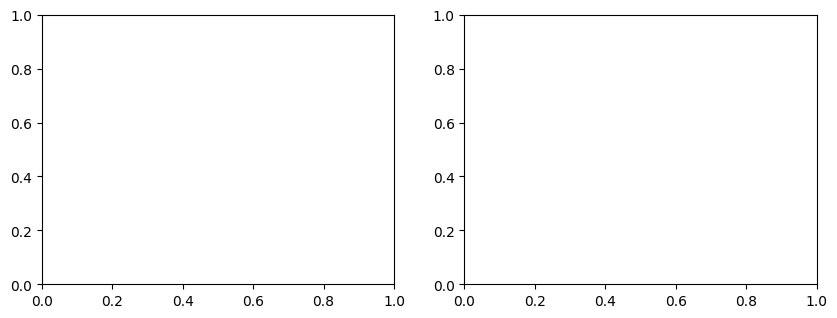

In [23]:
# Take mean over layers.

fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

# Make figure
Ds = [HIDDEN_DIMS[model] for model in HIDDEN_DIMS]

for i, mode in enumerate(MODES):
    for ds in DATASETS[:-1]:
        last_ckpt_df = results_df[(results_df['step']==143000) & (results_df['mode']==mode)]
        last_ckpt_df = last_ckpt_df[last_ckpt_df['words_coupled']==ds]

        # Mean
        agg_std = lambda x: np.sqrt(np.sum([x_**2 for x_ in x]))
        last_ckpt_mean = last_ckpt_df[['model', 'twonn_mean', 'pca_mean']]
        last_ckpt_std = last_ckpt_df[['model', 'twonn_std', 'pca_std']]
        means_df = last_ckpt_mean.groupby('model').agg(['mean'])
        std_df = last_ckpt_std.groupby('model').agg([agg_std])
        means_df = means_df.merge(std_df, on='model')
        means_df = means_df.reset_index()
        print(means_df)
        # Plot one line per datas
        for j, method in enumerate(['twonn', 'pca']):
            ys = np.array([means_df[means_df['model']==model][(f'{method}_mean','mean')] for model in HIDDEN_DIMS])[:,0]
            ystd = np.array([means_df[means_df['model']==model][(f'{method}_std','<lambda>')] for model in HIDDEN_DIMS])[:,0]
            
            axs[j].plot(
                Ds, 
                ys, 
                label=f'{ds}',
                linestyle='--' if mode == 'shuffled' else None,
                marker='o' if mode == 'sane' else '^',
                alpha=0.8,
                color=DATASET_COLORS[ds-1]
            )
            axs[j].fill_between(Ds, ys - ystd, ys + ystd, alpha=0.4, color=DATASET_COLORS[ds-1])
            if method == 'twonn':
                axs[j].set_ylabel(r'TwoNN $I_d$', fontsize=13)
            else:
                axs[j].set_ylabel(r'PCA $d$', fontsize=13)

            axs[j].set_xlabel(r'hidden dimension $D$', fontsize=14)
            axs[j].grid(True)
            # axs[j].set_yticklabels(axs[j].get_yticklabels(), fontsize=10)
            # axs[j].set_xticklabels(axs[j].get_xticklabels(), fontsize=10)

        # Custom legend handles for both subplots
        custom_lines = [Line2D([0], [0], color=color, marker='o', lw=2) for color in DATASET_COLORS] + \
            [Line2D([0], [0], color='gray', lw=2), Line2D([0], [0], color='gray', linestyle='--', lw=2)]
        
        fig.legend(custom_lines, 
                   [1, 2, 3, 4, 'sane', 'shuffled'], 
                   loc='upper center', ncol=3, title='# words coupled', bbox_to_anchor=(0.705,0.95))
        # fig.tight_layout()

# Make figure
Ds = [HIDDEN_DIMS[model] for model in HIDDEN_DIMS]
m1 = 'twonn'
m2 = 'pca'

for i, mode in enumerate(MODES):
    for ds in ['pile']:
        last_ckpt_df = results_df[(results_df['step']==143000) & (results_df['mode']==ds)]

        # Mean
        agg_std = lambda x: np.sqrt(np.sum([x_**2 for x_ in x]))
        last_ckpt_mean = last_ckpt_df[['model', f'{m1}_mean', f'{m2}_mean']]
        last_ckpt_std = last_ckpt_df[['model', f'{m1}_std', f'{m2}_std']]
        means_df = last_ckpt_mean.groupby('model').agg(['mean'])
        std_df = last_ckpt_std.groupby('model').agg([agg_std])
        means_df = means_df.merge(std_df, on='model')
        means_df = means_df.reset_index()

        # Plot one line per datas
        for j, method in enumerate([m1, m2]):
            ys = np.array([means_df[means_df['model']==model][(f'{method}_mean','mean')] for model in HIDDEN_DIMS])[:,0]
            ystd = np.array([means_df[means_df['model']==model][(f'{method}_std','<lambda>')] for model in HIDDEN_DIMS])[:,0]
            
            axs[j % 2].plot(
                Ds, 
                ys, 
                label=f'{ds}',
                linestyle='--' if mode == 'shuffled' else None,
                marker='o',
                alpha=0.8,
                color=DATASET_COLORS[-1]
            )
            axs[j % 2].fill_between(Ds, ys - ystd, ys + ystd, alpha=0.4, color=DATASET_COLORS[-1])
            if method == 'twonn':
                axs[j % 2].set_ylabel(r'TwoNN $I_d$', fontsize=13)
            else:
                axs[j % 2].set_ylabel(r'PCA $d$', fontsize=13)

            axs[j % 2].set_xlabel(r'hidden dimension $D$', fontsize=14)
            if j == 0:
                axs[j].set_ylim([8, 40])
            else:
                axs[j].set_ylim([-100, 4800])
            axs[j % 2].grid(True)
            # axs[j].set_yticklabels(axs[j].get_yticklabels(), fontsize=10)
            # axs[j].set_xticklabels(axs[j].get_xticklabels(), fontsize=10)

        # Custom legend handles for both subplots
        # custom_lines = [Line2D([0], [0], color=color, marker='o', lw=2) for color in DATASET_COLORS] + \
            # [Line2D([0], [0], color='gray', lw=2), Line2D([0], [0], color='gray', linestyle='--', lw=2)]
        
        # fig.legend(custom_lines, 
                   # [1, 2, 3, 4, 'sane', 'shuffled'], 
                   # loc='upper center', ncol=3, title='# words coupled', bbox_to_anchor=(0.705,0.95))
        # fig.tight_layout()

# for ext in ['svg', 'png', 'pdf']:
    # fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/id_model_size_appendix.{ext}')

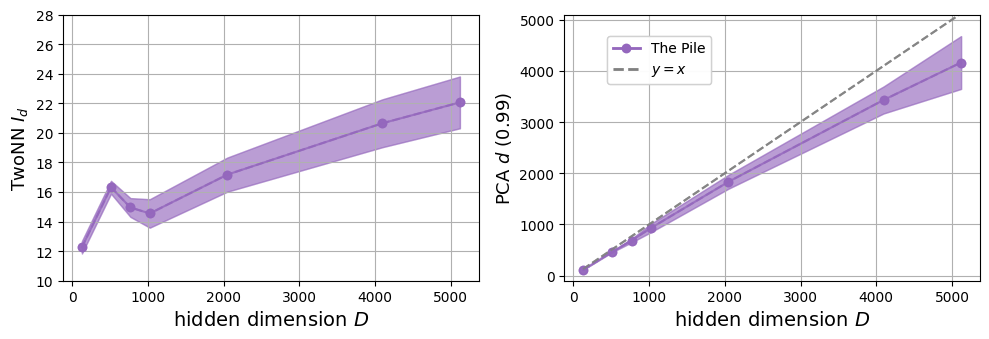

In [52]:
# Take mean over layers.
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))

# Make figure
Ds = [HIDDEN_DIMS[model] for model in HIDDEN_DIMS]
m1 = 'twonn'
m2 = 'pca'

for i, mode in enumerate(MODES):
    for ds in ['pile']:
        last_ckpt_df = results_df[(results_df['step']==143000) & (results_df['mode']==ds)]

        # Mean
        agg_std = lambda x: np.sqrt(np.sum([x_**2 for x_ in x]))
        last_ckpt_mean = last_ckpt_df[['model', f'{m1}_mean', f'{m2}_mean']]
        last_ckpt_std = last_ckpt_df[['model', f'{m1}_std', f'{m2}_std']]
        means_df = last_ckpt_mean.groupby('model').agg(['mean'])
        std_df = last_ckpt_std.groupby('model').agg([agg_std])
        means_df = means_df.merge(std_df, on='model')
        means_df = means_df.reset_index()

        # Plot one line per datas
        for j, method in enumerate([m1, m2]):
            ys = np.array([means_df[means_df['model']==model][(f'{method}_mean','mean')] for model in HIDDEN_DIMS])[:,0]
            ystd = np.array([means_df[means_df['model']==model][(f'{method}_std','<lambda>')] for model in HIDDEN_DIMS])[:,0]
            
            axs[j % 2].plot(
                Ds, 
                ys, 
                label=f'{ds}',
                linestyle='--' if mode == 'shuffled' else None,
                marker='o',
                alpha=0.8,
                color=DATASET_COLORS[-1]
            )
            axs[j % 2].fill_between(Ds, ys - ystd, ys + ystd, alpha=0.4, color=DATASET_COLORS[-1])

            if j == 1:
                axs[j].plot(Ds, Ds, label='y=x', linestyle='--', marker=None, alpha=0.8, color='gray')
            
            if method == 'twonn':
                axs[j % 2].set_ylabel(r'TwoNN $I_d$', fontsize=13)
            else:
                axs[j % 2].set_ylabel(r'PCA $d$ (0.99)', fontsize=13)

            axs[j % 2].set_xlabel(r'hidden dimension $D$', fontsize=14)
            if j == 0:
                axs[j].set_ylim([10, 28])
            else:
                axs[j].set_ylim([-100, 5100])
            axs[j % 2].grid(True)
            # axs[j].set_yticklabels(axs[j].get_yticklabels(), fontsize=10)
            # axs[j].set_xticklabels(axs[j].get_xticklabels(), fontsize=10)

        # Custom legend handles for both subplots
        custom_lines = [Line2D([0], [0], color=DATASET_COLORS[-1], marker='o', lw=2)] + \
            [Line2D([0], [0], color='gray', linestyle='--', lw=2)]
        
        fig.legend(custom_lines, 
                   ['The Pile', r'$y=x$'], 
                   loc='upper left', ncol=1, bbox_to_anchor=(0.605,0.9))
        fig.tight_layout()

for ext in ['svg', 'png', 'pdf']:
    fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/pile_id_model_size_appendix.{ext}')

## Thomas plot ID over layers

TypeError: unsupported operand type(s) for -: 'str' and 'int'

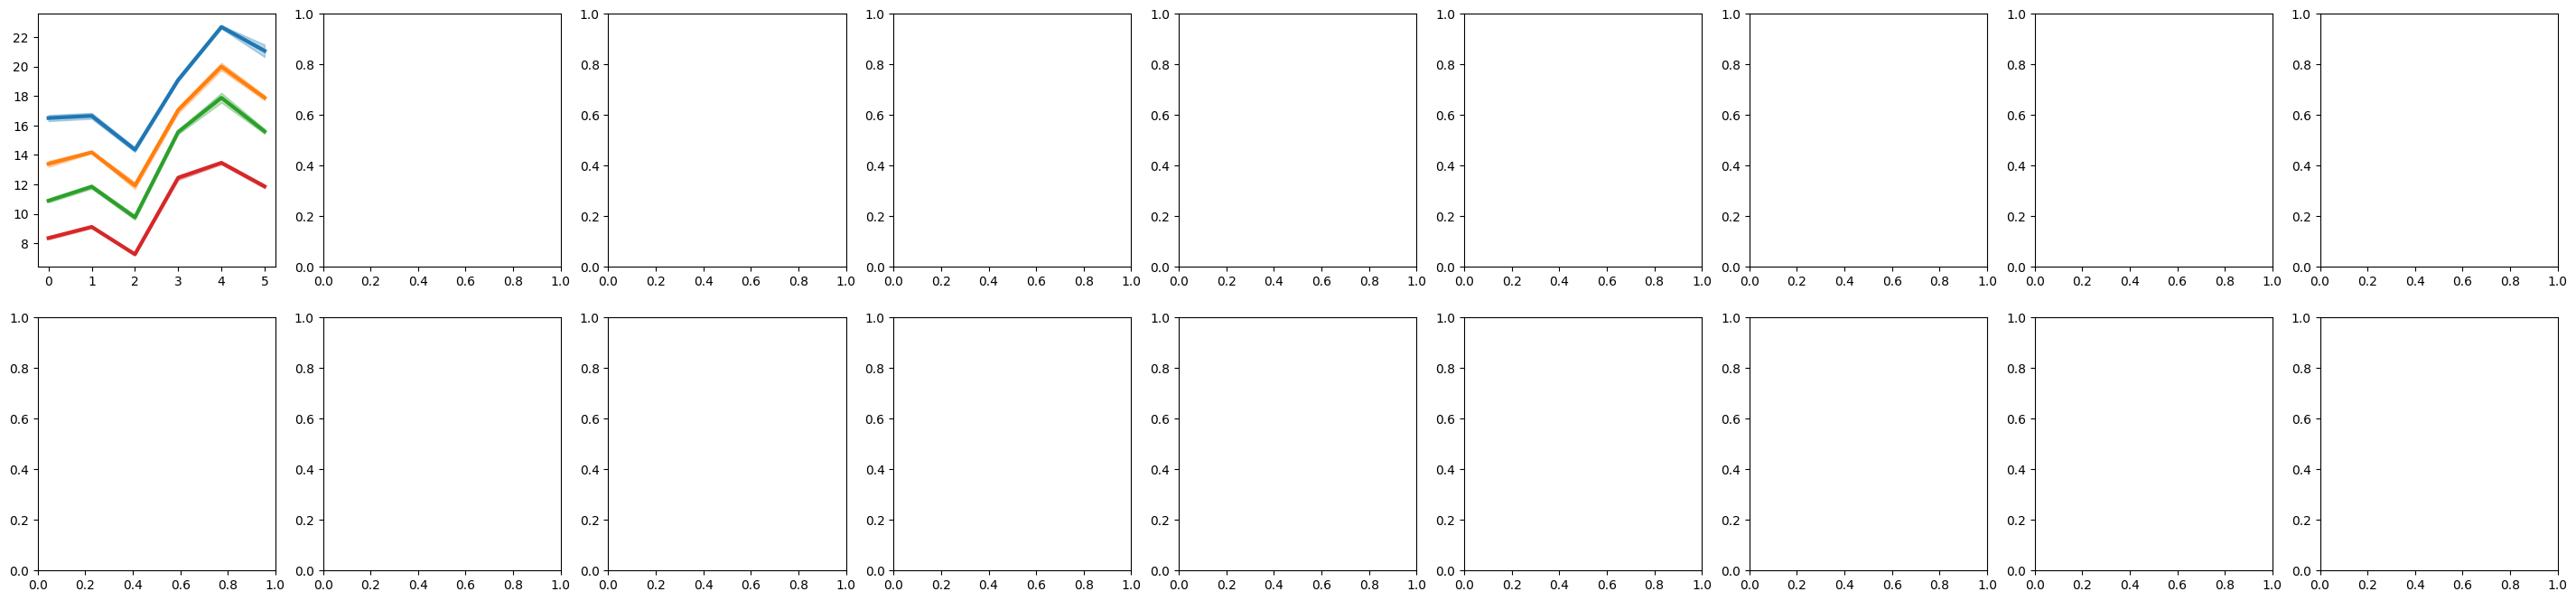

In [19]:
# sizes = SCALING_SIZES 
sizes = list(HIDDEN_DIMS.keys())
# 
fig, axs = plt.subplots(2, len(sizes), figsize=(4 * len(sizes), 8))

for i, method in enumerate(['twonn', 'pca']):
    for j, model in enumerate(sizes):
        # plot over layers
        ax = axs[i][j]

        # first get the x and y and std for sane
        model_df = results_df[(results_df['model']==model) & (results_df['step']==143000)]

        for mode in ['sane', 'shuffled']:
            setting_df = model_df[model_df['mode'] == mode]

            for ds in DATASETS:
                df = setting_df[setting_df['words_coupled']==ds]
                ax.plot(
                    df['layer'], 
                    df[f'{method}_mean'], 
                    color=DATASET_COLORS[ds-1], 
                    marker=None,#'o' if mode == 'sane' else '^',
                    linestyle='--' if mode == 'shuffled' else None,
                    linewidth=3,
                    # markersize=6
                )
                ax.fill_between(df['layer'], 
                    df[f'{method}_mean'] - df[f'{method}_std'],
                    df[f'{method}_mean'] + df[f'{method}_std'],
                    alpha=0.3,
                    color=DATASET_COLORS[ds-1]
                               )
        ax.set_xlim([0, len(df['layer'])])
        
        if i == 0:
            ax.set_ylim([5, 41])
        else:
            ax.set_ylim([0, 3000])
        if i == 0:
            ax.set_title(model, fontsize=20)
        ax.grid(True)
        # ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        if i == 1: 
            ax.set_xlabel('layer', fontsize=18)

        if j == 0:
            if i == 0:
                ax.set_ylabel(r'TwoNN $I_d$', fontsize=20)
            else:
                ax.set_ylabel(r'PCA $d$ (0.99)', fontsize=20)

# Custom legend handles for both subplots
custom_lines = [Line2D([0], [0], color=color, marker=None, lw=4) for color in DATASET_COLORS] + \
    [Line2D([0], [0], color='gray', lw=4), Line2D([0], [0], color='gray', linestyle='--', lw=4)]

fig.legend(custom_lines, 
           [1, 2, 3, 4, 'sane', 'shuffled'], 
           ncol=1, title='# words coupled', bbox_to_anchor=(1.2, 0.96), fontsize=16, title_fontsize=16)
fig.tight_layout()

# for ext in ['svg', 'png', 'pdf']:
    # fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/nonlinear_linear_id_app.{ext}', bbox_inches='tight')

,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,280.6,0.489898,32.260030,0.177227,23.883845,0.490637,22.838385,0.046405,sane,1,143000,1024,410m,0
1,467.8,0.979796,12.456535,0.229823,25.545017,0.232835,22.236261,0.060952,sane,1,143000,1024,410m,1
2,540.8,0.979796,15.013469,0.246923,27.724341,0.185379,24.192432,0.073429,sane,1,143000,1024,410m,2
3,521.6,0.489898,38.556132,0.422355,30.950583,0.293107,28.890062,0.096338,sane,1,143000,1024,410m,3
4,557.6,0.489898,40.298358,0.357010,27.947891,0.321126,27.912213,0.084591,sane,1,143000,1024,410m,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,904.0,16.260381,11.770173,3.738392,21.771003,0.227745,28.422911,0.160119,shuffled,pile,143000,1024,410m,19
20,909.4,13.335666,15.451820,5.120906,22.108704,0.342263,28.375583,0.143812,shuffled,pile,143000,1024,410m,20
21,900.2,8.231646,9.021876,0.315171,23.119064,0.216295,28.533476,0.133809,shuffled,pile,143000,1024,410m,21
22,918.0,1.414214,18.370383,0.217141,23.851986,0.281847,28.509223,0.156149,shuffled,pile,143000,1024,410m,22


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,411.6,0.489898,27.631613,0.315966,20.765240,0.189745,20.566789,0.080612,sane,1,143000,2048,1.4b,0
1,675.6,1.854724,6.210318,0.080790,24.007196,0.261856,21.440085,0.027601,sane,1,143000,2048,1.4b,1
2,814.8,2.227106,7.290185,0.091720,25.912350,0.147197,22.663605,0.054319,sane,1,143000,2048,1.4b,2
3,927.6,1.356466,19.855163,0.272334,30.694810,0.491745,28.539205,0.050466,sane,1,143000,2048,1.4b,3
4,959.6,0.489898,72.149783,0.296863,26.959173,0.168667,27.949455,0.084918,sane,1,143000,2048,1.4b,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,1804.2,16.191356,22.913233,5.200290,23.282648,0.611094,33.475803,0.140479,shuffled,pile,143000,2048,1.4b,19
20,1813.6,13.792752,25.280350,4.907636,23.820555,0.601866,33.506465,0.169785,shuffled,pile,143000,2048,1.4b,20
21,1807.8,11.034491,20.312240,1.181158,24.420499,0.664171,33.378799,0.240586,shuffled,pile,143000,2048,1.4b,21
22,1809.2,4.445222,25.843792,0.553480,24.941945,0.745681,32.450450,0.204718,shuffled,pile,143000,2048,1.4b,22


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,623.0,0.000000,71.581431,0.755075,33.125672,0.344852,32.945440,0.118725,sane,1,143000,4096,6.9b,0
1,1307.0,2.000000,51.919036,0.933875,34.025617,0.492001,32.944017,0.123736,sane,1,143000,4096,6.9b,1
2,1569.4,0.800000,49.933696,0.532940,32.376908,0.204943,30.684195,0.126049,sane,1,143000,4096,6.9b,2
3,1475.6,1.959592,62.414069,0.556565,29.606058,0.271412,28.292890,0.107022,sane,1,143000,4096,6.9b,3
4,1499.8,1.469694,81.791248,0.388752,21.674172,0.169359,23.744207,0.138990,sane,1,143000,4096,6.9b,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3428.6,18.039956,23.951098,5.573522,26.193327,0.310018,37.379959,0.220076,shuffled,pile,143000,4096,6.9b,27
28,3420.6,16.206172,24.306270,4.937769,26.852846,0.205008,37.725428,0.182858,shuffled,pile,143000,4096,6.9b,28
29,3410.6,14.840485,24.686065,4.344737,26.958980,0.137143,37.240965,0.166284,shuffled,pile,143000,4096,6.9b,29
30,3370.6,11.706409,23.139670,2.497343,26.923228,0.151591,35.652506,0.185630,shuffled,pile,143000,4096,6.9b,30


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,280.6,0.489898,32.260030,0.177227,23.883845,0.490637,22.838385,0.046405,sane,1,143000,1024,410m,0
1,467.8,0.979796,12.456535,0.229823,25.545017,0.232835,22.236261,0.060952,sane,1,143000,1024,410m,1
2,540.8,0.979796,15.013469,0.246923,27.724341,0.185379,24.192432,0.073429,sane,1,143000,1024,410m,2
3,521.6,0.489898,38.556132,0.422355,30.950583,0.293107,28.890062,0.096338,sane,1,143000,1024,410m,3
4,557.6,0.489898,40.298358,0.357010,27.947891,0.321126,27.912213,0.084591,sane,1,143000,1024,410m,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,904.0,16.260381,11.770173,3.738392,21.771003,0.227745,28.422911,0.160119,shuffled,pile,143000,1024,410m,19
20,909.4,13.335666,15.451820,5.120906,22.108704,0.342263,28.375583,0.143812,shuffled,pile,143000,1024,410m,20
21,900.2,8.231646,9.021876,0.315171,23.119064,0.216295,28.533476,0.133809,shuffled,pile,143000,1024,410m,21
22,918.0,1.414214,18.370383,0.217141,23.851986,0.281847,28.509223,0.156149,shuffled,pile,143000,1024,410m,22


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,411.6,0.489898,27.631613,0.315966,20.765240,0.189745,20.566789,0.080612,sane,1,143000,2048,1.4b,0
1,675.6,1.854724,6.210318,0.080790,24.007196,0.261856,21.440085,0.027601,sane,1,143000,2048,1.4b,1
2,814.8,2.227106,7.290185,0.091720,25.912350,0.147197,22.663605,0.054319,sane,1,143000,2048,1.4b,2
3,927.6,1.356466,19.855163,0.272334,30.694810,0.491745,28.539205,0.050466,sane,1,143000,2048,1.4b,3
4,959.6,0.489898,72.149783,0.296863,26.959173,0.168667,27.949455,0.084918,sane,1,143000,2048,1.4b,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,1804.2,16.191356,22.913233,5.200290,23.282648,0.611094,33.475803,0.140479,shuffled,pile,143000,2048,1.4b,19
20,1813.6,13.792752,25.280350,4.907636,23.820555,0.601866,33.506465,0.169785,shuffled,pile,143000,2048,1.4b,20
21,1807.8,11.034491,20.312240,1.181158,24.420499,0.664171,33.378799,0.240586,shuffled,pile,143000,2048,1.4b,21
22,1809.2,4.445222,25.843792,0.553480,24.941945,0.745681,32.450450,0.204718,shuffled,pile,143000,2048,1.4b,22


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,623.0,0.000000,71.581431,0.755075,33.125672,0.344852,32.945440,0.118725,sane,1,143000,4096,6.9b,0
1,1307.0,2.000000,51.919036,0.933875,34.025617,0.492001,32.944017,0.123736,sane,1,143000,4096,6.9b,1
2,1569.4,0.800000,49.933696,0.532940,32.376908,0.204943,30.684195,0.126049,sane,1,143000,4096,6.9b,2
3,1475.6,1.959592,62.414069,0.556565,29.606058,0.271412,28.292890,0.107022,sane,1,143000,4096,6.9b,3
4,1499.8,1.469694,81.791248,0.388752,21.674172,0.169359,23.744207,0.138990,sane,1,143000,4096,6.9b,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3428.6,18.039956,23.951098,5.573522,26.193327,0.310018,37.379959,0.220076,shuffled,pile,143000,4096,6.9b,27
28,3420.6,16.206172,24.306270,4.937769,26.852846,0.205008,37.725428,0.182858,shuffled,pile,143000,4096,6.9b,28
29,3410.6,14.840485,24.686065,4.344737,26.958980,0.137143,37.240965,0.166284,shuffled,pile,143000,4096,6.9b,29
30,3370.6,11.706409,23.139670,2.497343,26.923228,0.151591,35.652506,0.185630,shuffled,pile,143000,4096,6.9b,30


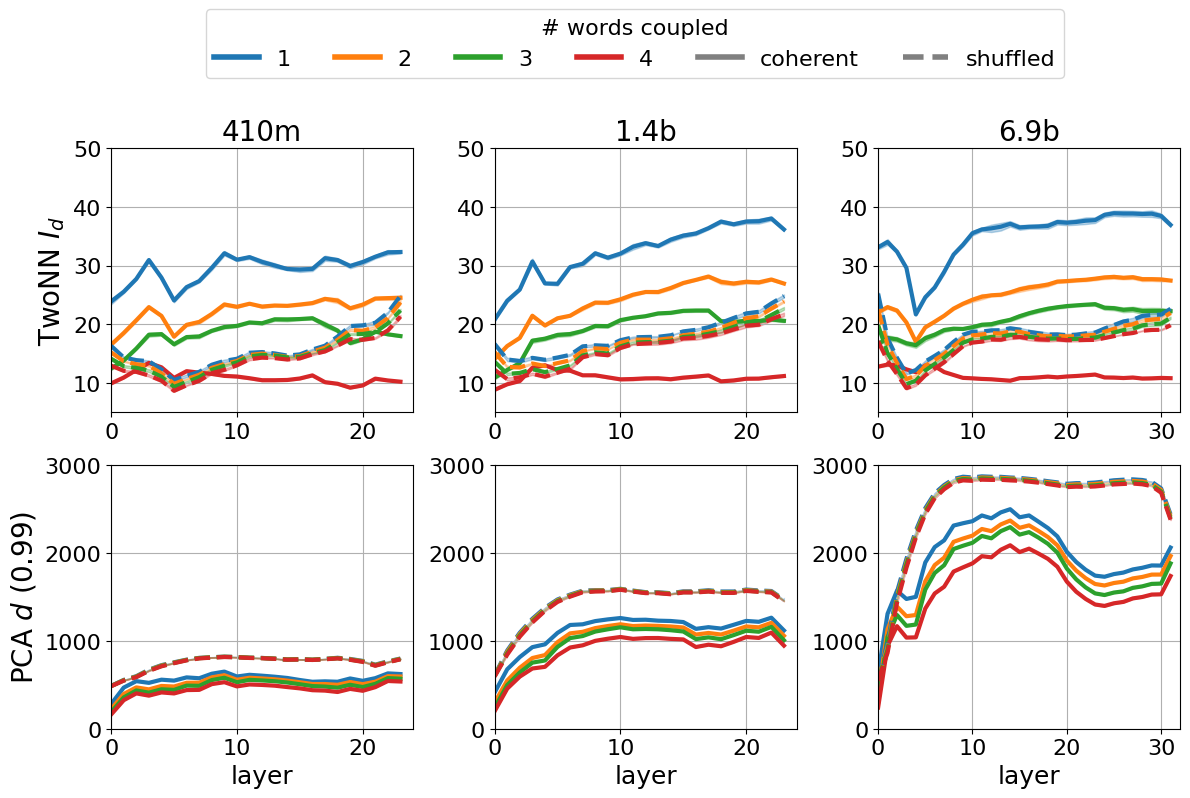

In [23]:
sizes = SCALING_SIZES 
# sizes = OTHER_MODELS
# 
fig, axs = plt.subplots(2, len(sizes), figsize=(4 * len(sizes), 7))

for i, method in enumerate(['twonn', 'pca']):
    for j, model in enumerate(sizes):
        # plot over layers
        ax = axs[i][j]

        # first get the x and y and std for sane
        model_df = results_df[(results_df['model']==model) & (results_df['step']==143000)]
        display(model_df)
        for mode in ['sane', 'shuffled']:
            setting_df = model_df[model_df['mode'] == mode]

            for ds in DATASETS:
                if ds in ('pile', 'pile_shuffled'): continue
                    
                df = setting_df[setting_df['words_coupled']==ds]
                ax.plot(
                    df['layer'], 
                    df[f'{method}_mean'], 
                    color=DATASET_COLORS[ds-1], 
                    marker=None,#'o' if mode == 'sane' else '^',
                    linestyle='--' if mode == 'shuffled' else None,
                    linewidth=3,
                    # markersize=6
                )
                ax.fill_between(df['layer'], 
                    df[f'{method}_mean'] - df[f'{method}_std'],
                    df[f'{method}_mean'] + df[f'{method}_std'],
                    alpha=0.3,
                    color=DATASET_COLORS[ds-1]
                               )
        ax.set_xlim([0, len(df['layer'])])
        
        if i == 0:
            ax.set_ylim([5, 50])
        else:
            ax.set_ylim([0, 3000])
        if i == 0:
            ax.set_title(model, fontsize=20)
        ax.grid(True)
        # ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        if i == 1: 
            ax.set_xlabel('layer', fontsize=18)

        if j == 0:
            if i == 0:
                ax.set_ylabel(r'TwoNN $I_d$', fontsize=20)
            else:
                ax.set_ylabel(r'PCA $d$ (0.99)', fontsize=20)

# Custom legend handles for both subplots
custom_lines = [Line2D([0], [0], color=color, marker=None, lw=4) for color in DATASET_COLORS[:-1]] + \
    [Line2D([0], [0], color='gray', lw=4), Line2D([0], [0], color='gray', linestyle='--', lw=4)]

fig.legend(custom_lines, 
           [1, 2, 3, 4, 'coherent', 'shuffled'], 
           ncol=6, title='# words coupled', bbox_to_anchor=(0.9, 1.15), fontsize=16, title_fontsize=16)
fig.tight_layout()

for ext in ['svg', 'png', 'pdf']:
    fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/acl_figure_3.{ext}', bbox_inches='tight')

In [63]:
results_df[(results_df['model']=='6.9b') & (results_df['words_coupled']=='pile')]

,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,3069.6,6.019967,157.746993,6.546843,24.167530,0.961359,95.821210,2.306094,sane,pile,0,4096,6.9b,0
1,3169.0,3.847077,179.240963,7.348636,28.146174,1.081223,94.910493,3.681333,sane,pile,0,4096,6.9b,1
2,3191.8,3.059412,194.766489,7.734664,29.987918,1.161018,90.037784,3.150235,sane,pile,0,4096,6.9b,2
3,3198.0,2.828427,207.771884,8.062280,31.137655,1.165688,87.184730,2.186796,sane,pile,0,4096,6.9b,3
4,3197.2,2.400000,219.501862,8.351745,31.716588,1.213475,84.599026,1.947780,sane,pile,0,4096,6.9b,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,3547.6,12.658594,25.470275,5.855827,24.214250,0.442261,41.583380,1.034202,sane,pile,143000,4096,6.9b,27
28,3552.2,11.391225,28.021219,6.122101,24.719849,0.505555,42.083989,1.094663,sane,pile,143000,4096,6.9b,28
29,3553.8,10.438391,31.346156,6.581139,24.933990,0.541114,42.005204,0.990365,sane,pile,143000,4096,6.9b,29
30,3541.0,8.294577,36.930154,6.164460,24.908246,0.545055,40.026832,0.630351,sane,pile,143000,4096,6.9b,30


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,884.8,0.748331,56.423674,1.590220,7.168161,0.117151,21.381921,0.434173,sane,pile,0,1024,410m,0
1,931.8,0.748331,45.485682,3.050037,7.265349,0.120846,29.551906,0.354828,sane,pile,0,1024,410m,1
2,946.8,0.748331,42.459217,2.612506,8.084640,0.102131,27.395784,0.487686,sane,pile,0,1024,410m,2
3,949.6,0.489898,99.084861,4.345141,9.611016,0.123723,28.159501,0.484385,sane,pile,0,1024,410m,3
4,957.0,0.000000,166.316137,3.484656,10.613114,0.112084,28.401990,0.361126,sane,pile,0,1024,410m,4
5,931.4,18.958903,90.732554,102.620075,12.437048,0.162254,31.352014,0.347313,sane,pile,0,1024,410m,5
6,939.6,16.181471,99.428104,112.168023,13.275080,0.161892,29.888405,0.339481,sane,pile,0,1024,410m,6
7,939.2,16.606023,104.262776,118.792869,14.022439,0.131931,30.318568,0.154673,sane,pile,0,1024,410m,7
8,927.6,21.058015,92.795906,106.868778,14.182098,0.172308,30.374170,0.191374,sane,pile,0,1024,410m,8
9,926.8,22.157617,88.613576,102.054224,14.603503,0.203886,31.890150,0.112336,sane,pile,0,1024,410m,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,884.0,0.632456,57.300761,0.883282,7.486882,0.314170,21.430856,0.207740,shuffled,pile,0,1024,410m,0
1,931.0,0.632456,47.490582,1.486622,8.030393,0.240628,29.701646,0.494900,shuffled,pile,0,1024,410m,1
2,946.4,0.489898,48.855236,1.394182,8.912932,0.227934,27.744634,0.300530,shuffled,pile,0,1024,410m,2
3,949.2,0.400000,104.984502,1.324416,10.525733,0.301194,31.331374,0.300511,shuffled,pile,0,1024,410m,3
4,954.8,0.400000,154.473434,1.132285,11.706497,0.323626,31.211152,0.247392,shuffled,pile,0,1024,410m,4
5,923.8,21.282857,79.487677,89.577385,13.870000,0.357438,33.771795,0.356961,shuffled,pile,0,1024,410m,5
6,931.4,18.586016,83.528975,93.625796,15.361554,0.370045,30.984101,0.404431,shuffled,pile,0,1024,410m,6
7,929.6,19.683496,84.258802,95.161294,16.535039,0.380725,30.228401,0.424308,shuffled,pile,0,1024,410m,7
8,915.2,25.856527,75.813918,86.810222,16.701331,0.368859,29.225945,0.497682,shuffled,pile,0,1024,410m,8
9,911.0,27.640550,75.554697,86.732643,17.342632,0.447431,30.986580,0.537305,shuffled,pile,0,1024,410m,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,1604.6,2.244994,109.231161,3.537398,7.480436,0.064118,41.950137,1.044777,sane,pile,0,2048,1.4b,0
1,1787.8,1.720465,153.505002,4.881049,8.632975,0.187562,42.809896,1.262135,sane,pile,0,2048,1.4b,1
2,1851.6,1.356466,142.019600,3.376967,9.876594,0.247953,43.240325,1.395519,sane,pile,0,2048,1.4b,2
3,1870.6,1.356466,241.155747,5.806533,11.549033,0.190941,46.623217,1.777645,sane,pile,0,2048,1.4b,3
4,1825.6,42.358470,82.680626,113.651830,13.720832,0.256291,49.664424,0.977480,sane,pile,0,2048,1.4b,4
5,1833.4,41.364719,69.673493,103.061726,14.844314,0.253030,52.219312,1.610339,sane,pile,0,2048,1.4b,5
6,1834.2,42.400000,50.225407,74.676817,16.475023,0.327036,52.738727,1.553541,sane,pile,0,2048,1.4b,6
7,1836.6,42.884030,46.915417,68.974759,16.897936,0.311960,53.666941,1.204739,sane,pile,0,2048,1.4b,7
8,1832.8,41.469989,47.054308,67.902801,17.770695,0.270629,53.952933,0.944459,sane,pile,0,2048,1.4b,8
9,1829.0,41.347309,49.664784,72.371977,18.581202,0.323764,51.817487,1.558182,sane,pile,0,2048,1.4b,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,1596.8,2.315167,112.861262,1.534124,8.472239,0.229723,45.620535,0.639570,shuffled,pile,0,2048,1.4b,0
1,1783.4,1.356466,160.036005,2.832186,10.002193,0.099819,44.375829,1.052710,shuffled,pile,0,2048,1.4b,1
2,1849.2,0.979796,155.738853,2.544315,11.071033,0.147548,42.480053,1.079127,shuffled,pile,0,2048,1.4b,2
3,1868.6,0.800000,239.946378,4.738690,12.880172,0.152253,48.654237,1.300101,shuffled,pile,0,2048,1.4b,3
4,1821.8,44.422517,104.894572,124.595656,15.101468,0.160120,48.464808,0.487132,shuffled,pile,0,2048,1.4b,4
5,1825.4,46.486987,87.443805,109.978103,16.302846,0.177945,45.258297,1.327254,shuffled,pile,0,2048,1.4b,5
6,1819.2,49.239821,77.245547,104.587611,18.676318,0.239452,44.723087,0.775271,shuffled,pile,0,2048,1.4b,6
7,1816.2,50.909331,66.190130,87.241106,19.434341,0.236421,44.352299,0.479663,shuffled,pile,0,2048,1.4b,7
8,1808.4,50.448389,62.827050,80.540694,20.228544,0.159087,42.561594,0.845497,shuffled,pile,0,2048,1.4b,8
9,1793.0,51.509222,65.722068,84.005430,20.961764,0.281684,41.940615,0.388507,shuffled,pile,0,2048,1.4b,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,2569.4,9.393615,33.630701,2.007249,8.618594,0.181873,70.672943,2.218688,sane,pile,0,4096,6.9b,0
1,3046.2,6.493073,93.716637,5.455864,8.819827,0.232022,61.945340,0.942415,sane,pile,0,4096,6.9b,1
2,3307.6,5.200000,157.445186,5.235945,10.208380,0.195628,64.018611,1.284338,sane,pile,0,4096,6.9b,2
3,3376.6,21.425219,112.019497,65.025861,12.266348,0.248228,62.154044,0.287405,sane,pile,0,4096,6.9b,3
4,3208.6,104.118394,6.524986,3.634596,14.522101,0.212387,63.043088,1.275684,sane,pile,0,4096,6.9b,4
5,3262.8,100.692403,5.815035,3.005380,16.193282,0.203637,67.834550,2.488950,sane,pile,0,4096,6.9b,5
6,3330.6,88.192063,6.692004,3.578856,18.088941,0.224041,68.366830,2.202096,sane,pile,0,4096,6.9b,6
7,3363.6,80.026496,7.408516,4.034141,19.608724,0.234573,73.826797,1.306136,sane,pile,0,4096,6.9b,7
8,3405.2,73.016163,8.190569,4.541448,20.181786,0.247044,75.931649,1.252144,sane,pile,0,4096,6.9b,8
9,3436.6,66.560048,8.998910,5.039110,21.136057,0.279616,76.422058,2.081900,sane,pile,0,4096,6.9b,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,2565.0,7.155418,35.180439,1.189113,9.005440,0.297950,72.648573,1.290500,shuffled,pile,0,4096,6.9b,0
1,3032.6,6.151423,93.465572,2.770007,10.267416,0.188961,58.599431,1.537660,shuffled,pile,0,4096,6.9b,1
2,3304.0,4.000000,162.852666,1.959857,11.616269,0.068297,63.324471,1.651918,shuffled,pile,0,4096,6.9b,2
3,3380.2,17.022338,131.893591,60.251070,13.943665,0.123822,59.074496,1.555110,shuffled,pile,0,4096,6.9b,3
4,3255.8,104.879741,9.264972,5.778854,16.464953,0.194778,57.395185,1.613492,shuffled,pile,0,4096,6.9b,4
5,3298.2,105.925257,8.148858,4.882994,18.613833,0.222712,58.289283,2.256449,shuffled,pile,0,4096,6.9b,5
6,3347.6,94.753575,9.529961,5.886298,20.758761,0.275380,56.108453,1.980907,shuffled,pile,0,4096,6.9b,6
7,3358.2,89.199552,10.520132,6.585250,21.925439,0.377773,55.258783,1.706886,shuffled,pile,0,4096,6.9b,7
8,3378.8,83.576073,11.551144,7.307805,21.944658,0.437291,55.377664,1.242161,shuffled,pile,0,4096,6.9b,8
9,3389.6,77.561846,12.460495,7.827940,22.388595,0.413716,52.957785,0.910865,shuffled,pile,0,4096,6.9b,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,884.8,0.748331,56.423674,1.590220,7.168161,0.117151,21.381921,0.434173,sane,pile,0,1024,410m,0
1,931.8,0.748331,45.485682,3.050037,7.265349,0.120846,29.551906,0.354828,sane,pile,0,1024,410m,1
2,946.8,0.748331,42.459217,2.612506,8.084640,0.102131,27.395784,0.487686,sane,pile,0,1024,410m,2
3,949.6,0.489898,99.084861,4.345141,9.611016,0.123723,28.159501,0.484385,sane,pile,0,1024,410m,3
4,957.0,0.000000,166.316137,3.484656,10.613114,0.112084,28.401990,0.361126,sane,pile,0,1024,410m,4
5,931.4,18.958903,90.732554,102.620075,12.437048,0.162254,31.352014,0.347313,sane,pile,0,1024,410m,5
6,939.6,16.181471,99.428104,112.168023,13.275080,0.161892,29.888405,0.339481,sane,pile,0,1024,410m,6
7,939.2,16.606023,104.262776,118.792869,14.022439,0.131931,30.318568,0.154673,sane,pile,0,1024,410m,7
8,927.6,21.058015,92.795906,106.868778,14.182098,0.172308,30.374170,0.191374,sane,pile,0,1024,410m,8
9,926.8,22.157617,88.613576,102.054224,14.603503,0.203886,31.890150,0.112336,sane,pile,0,1024,410m,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,884.0,0.632456,57.300761,0.883282,7.486882,0.314170,21.430856,0.207740,shuffled,pile,0,1024,410m,0
1,931.0,0.632456,47.490582,1.486622,8.030393,0.240628,29.701646,0.494900,shuffled,pile,0,1024,410m,1
2,946.4,0.489898,48.855236,1.394182,8.912932,0.227934,27.744634,0.300530,shuffled,pile,0,1024,410m,2
3,949.2,0.400000,104.984502,1.324416,10.525733,0.301194,31.331374,0.300511,shuffled,pile,0,1024,410m,3
4,954.8,0.400000,154.473434,1.132285,11.706497,0.323626,31.211152,0.247392,shuffled,pile,0,1024,410m,4
5,923.8,21.282857,79.487677,89.577385,13.870000,0.357438,33.771795,0.356961,shuffled,pile,0,1024,410m,5
6,931.4,18.586016,83.528975,93.625796,15.361554,0.370045,30.984101,0.404431,shuffled,pile,0,1024,410m,6
7,929.6,19.683496,84.258802,95.161294,16.535039,0.380725,30.228401,0.424308,shuffled,pile,0,1024,410m,7
8,915.2,25.856527,75.813918,86.810222,16.701331,0.368859,29.225945,0.497682,shuffled,pile,0,1024,410m,8
9,911.0,27.640550,75.554697,86.732643,17.342632,0.447431,30.986580,0.537305,shuffled,pile,0,1024,410m,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,1604.6,2.244994,109.231161,3.537398,7.480436,0.064118,41.950137,1.044777,sane,pile,0,2048,1.4b,0
1,1787.8,1.720465,153.505002,4.881049,8.632975,0.187562,42.809896,1.262135,sane,pile,0,2048,1.4b,1
2,1851.6,1.356466,142.019600,3.376967,9.876594,0.247953,43.240325,1.395519,sane,pile,0,2048,1.4b,2
3,1870.6,1.356466,241.155747,5.806533,11.549033,0.190941,46.623217,1.777645,sane,pile,0,2048,1.4b,3
4,1825.6,42.358470,82.680626,113.651830,13.720832,0.256291,49.664424,0.977480,sane,pile,0,2048,1.4b,4
5,1833.4,41.364719,69.673493,103.061726,14.844314,0.253030,52.219312,1.610339,sane,pile,0,2048,1.4b,5
6,1834.2,42.400000,50.225407,74.676817,16.475023,0.327036,52.738727,1.553541,sane,pile,0,2048,1.4b,6
7,1836.6,42.884030,46.915417,68.974759,16.897936,0.311960,53.666941,1.204739,sane,pile,0,2048,1.4b,7
8,1832.8,41.469989,47.054308,67.902801,17.770695,0.270629,53.952933,0.944459,sane,pile,0,2048,1.4b,8
9,1829.0,41.347309,49.664784,72.371977,18.581202,0.323764,51.817487,1.558182,sane,pile,0,2048,1.4b,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,1596.8,2.315167,112.861262,1.534124,8.472239,0.229723,45.620535,0.639570,shuffled,pile,0,2048,1.4b,0
1,1783.4,1.356466,160.036005,2.832186,10.002193,0.099819,44.375829,1.052710,shuffled,pile,0,2048,1.4b,1
2,1849.2,0.979796,155.738853,2.544315,11.071033,0.147548,42.480053,1.079127,shuffled,pile,0,2048,1.4b,2
3,1868.6,0.800000,239.946378,4.738690,12.880172,0.152253,48.654237,1.300101,shuffled,pile,0,2048,1.4b,3
4,1821.8,44.422517,104.894572,124.595656,15.101468,0.160120,48.464808,0.487132,shuffled,pile,0,2048,1.4b,4
5,1825.4,46.486987,87.443805,109.978103,16.302846,0.177945,45.258297,1.327254,shuffled,pile,0,2048,1.4b,5
6,1819.2,49.239821,77.245547,104.587611,18.676318,0.239452,44.723087,0.775271,shuffled,pile,0,2048,1.4b,6
7,1816.2,50.909331,66.190130,87.241106,19.434341,0.236421,44.352299,0.479663,shuffled,pile,0,2048,1.4b,7
8,1808.4,50.448389,62.827050,80.540694,20.228544,0.159087,42.561594,0.845497,shuffled,pile,0,2048,1.4b,8
9,1793.0,51.509222,65.722068,84.005430,20.961764,0.281684,41.940615,0.388507,shuffled,pile,0,2048,1.4b,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,2569.4,9.393615,33.630701,2.007249,8.618594,0.181873,70.672943,2.218688,sane,pile,0,4096,6.9b,0
1,3046.2,6.493073,93.716637,5.455864,8.819827,0.232022,61.945340,0.942415,sane,pile,0,4096,6.9b,1
2,3307.6,5.200000,157.445186,5.235945,10.208380,0.195628,64.018611,1.284338,sane,pile,0,4096,6.9b,2
3,3376.6,21.425219,112.019497,65.025861,12.266348,0.248228,62.154044,0.287405,sane,pile,0,4096,6.9b,3
4,3208.6,104.118394,6.524986,3.634596,14.522101,0.212387,63.043088,1.275684,sane,pile,0,4096,6.9b,4
5,3262.8,100.692403,5.815035,3.005380,16.193282,0.203637,67.834550,2.488950,sane,pile,0,4096,6.9b,5
6,3330.6,88.192063,6.692004,3.578856,18.088941,0.224041,68.366830,2.202096,sane,pile,0,4096,6.9b,6
7,3363.6,80.026496,7.408516,4.034141,19.608724,0.234573,73.826797,1.306136,sane,pile,0,4096,6.9b,7
8,3405.2,73.016163,8.190569,4.541448,20.181786,0.247044,75.931649,1.252144,sane,pile,0,4096,6.9b,8
9,3436.6,66.560048,8.998910,5.039110,21.136057,0.279616,76.422058,2.081900,sane,pile,0,4096,6.9b,9


,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer
0,2565.0,7.155418,35.180439,1.189113,9.005440,0.297950,72.648573,1.290500,shuffled,pile,0,4096,6.9b,0
1,3032.6,6.151423,93.465572,2.770007,10.267416,0.188961,58.599431,1.537660,shuffled,pile,0,4096,6.9b,1
2,3304.0,4.000000,162.852666,1.959857,11.616269,0.068297,63.324471,1.651918,shuffled,pile,0,4096,6.9b,2
3,3380.2,17.022338,131.893591,60.251070,13.943665,0.123822,59.074496,1.555110,shuffled,pile,0,4096,6.9b,3
4,3255.8,104.879741,9.264972,5.778854,16.464953,0.194778,57.395185,1.613492,shuffled,pile,0,4096,6.9b,4
5,3298.2,105.925257,8.148858,4.882994,18.613833,0.222712,58.289283,2.256449,shuffled,pile,0,4096,6.9b,5
6,3347.6,94.753575,9.529961,5.886298,20.758761,0.275380,56.108453,1.980907,shuffled,pile,0,4096,6.9b,6
7,3358.2,89.199552,10.520132,6.585250,21.925439,0.377773,55.258783,1.706886,shuffled,pile,0,4096,6.9b,7
8,3378.8,83.576073,11.551144,7.307805,21.944658,0.437291,55.377664,1.242161,shuffled,pile,0,4096,6.9b,8
9,3389.6,77.561846,12.460495,7.827940,22.388595,0.413716,52.957785,0.910865,shuffled,pile,0,4096,6.9b,9


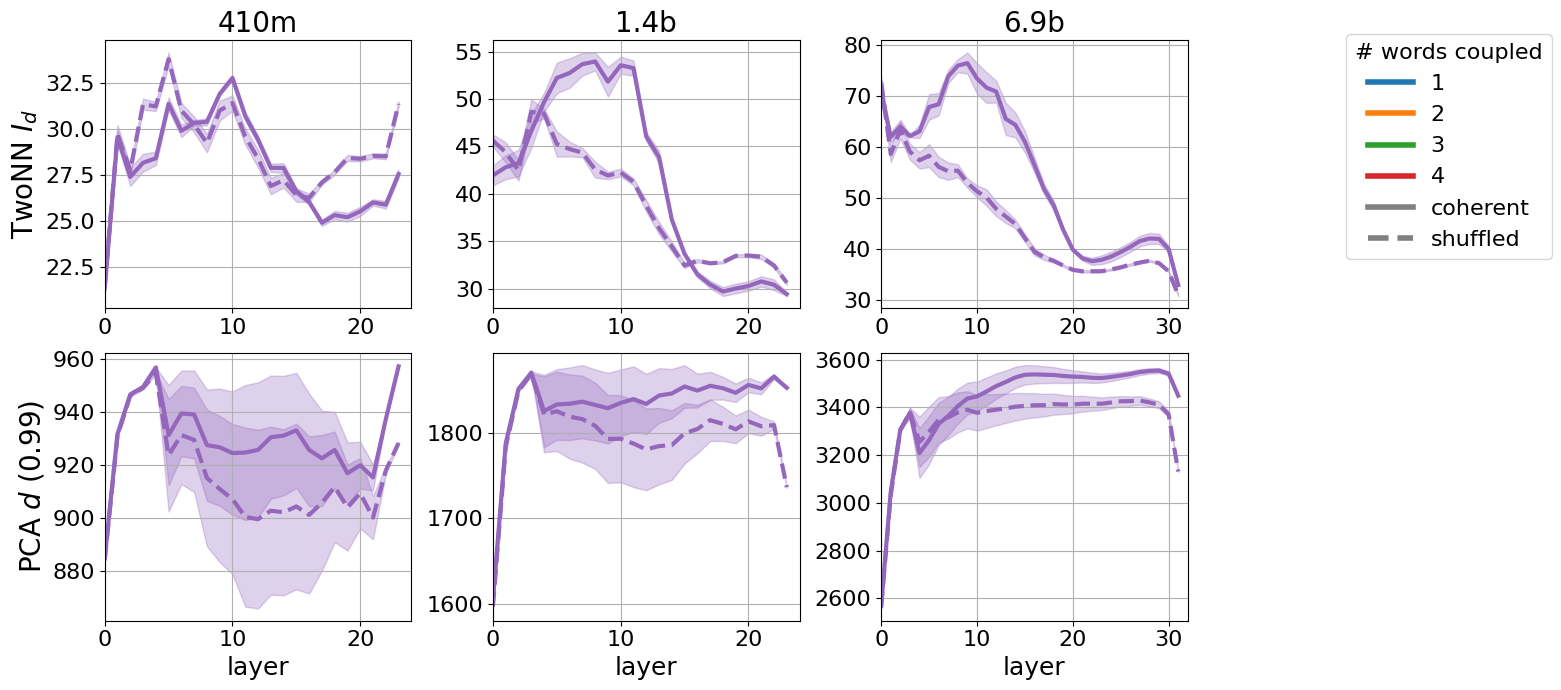

In [9]:
# sizes = SCALING_SIZES 
sizes = SCALING_SIZES
# 
fig, axs = plt.subplots(2, len(sizes), figsize=(4 * len(sizes), 7))

for i, method in enumerate(['mle', 'pca']):
    for j, model in enumerate(sizes):
        # plot over layers
        ax = axs[i][j]

        # first get the x and y and std for sane
        model_df = results_df[(results_df['model']==model) & (results_df['step']==0)]
        for mode in ['sane', 'shuffled']:
            setting_df = model_df[model_df['mode'] == mode]
            setting_df = setting_df[setting_df['step']==0]
            for ds in ['pile']:                    
                df = setting_df[setting_df['words_coupled']==ds]
                ax.plot(
                    df['layer'], 
                    df[f'{method}_mean'], 
                    color=DATASET_COLORS[4], 
                    marker=None,#'o' if mode == 'sane' else '^',
                    linestyle='--' if mode == 'shuffled' else None,
                    linewidth=3,
                    # markersize=6
                )
                ax.fill_between(df['layer'], 
                    df[f'{method}_mean'] - df[f'{method}_std'],
                    df[f'{method}_mean'] + df[f'{method}_std'],
                    alpha=0.3,
                    color=DATASET_COLORS[4]
                               )
        ax.set_xlim([0, len(df['layer'])])
        
        # if i == 0:
        #     ax.set_ylim([5, 50])
        # else:
        #     ax.set_ylim([0, 3000])
        if i == 0:
            ax.set_title(model, fontsize=20)
        ax.grid(True)
        # ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        if i == 1: 
            ax.set_xlabel('layer', fontsize=18)

        if j == 0:
            if i == 0:
                ax.set_ylabel(r'TwoNN $I_d$', fontsize=20)
            else:
                ax.set_ylabel(r'PCA $d$ (0.99)', fontsize=20)

# Custom legend handles for both subplots
custom_lines = [Line2D([0], [0], color=color, marker=None, lw=4) for color in DATASET_COLORS[:-1]] + \
    [Line2D([0], [0], color='gray', lw=4), Line2D([0], [0], color='gray', linestyle='--', lw=4)]

fig.legend(custom_lines, 
           [1, 2, 3, 4, 'coherent', 'shuffled'], 
           ncol=1, title='# words coupled', bbox_to_anchor=(1.3, 0.96), fontsize=16, title_fontsize=16)
fig.tight_layout()

for ext in ['svg', 'png', 'pdf']:
    fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/other_models_nonlinear_linear_id_app.{ext}', bbox_inches='tight')

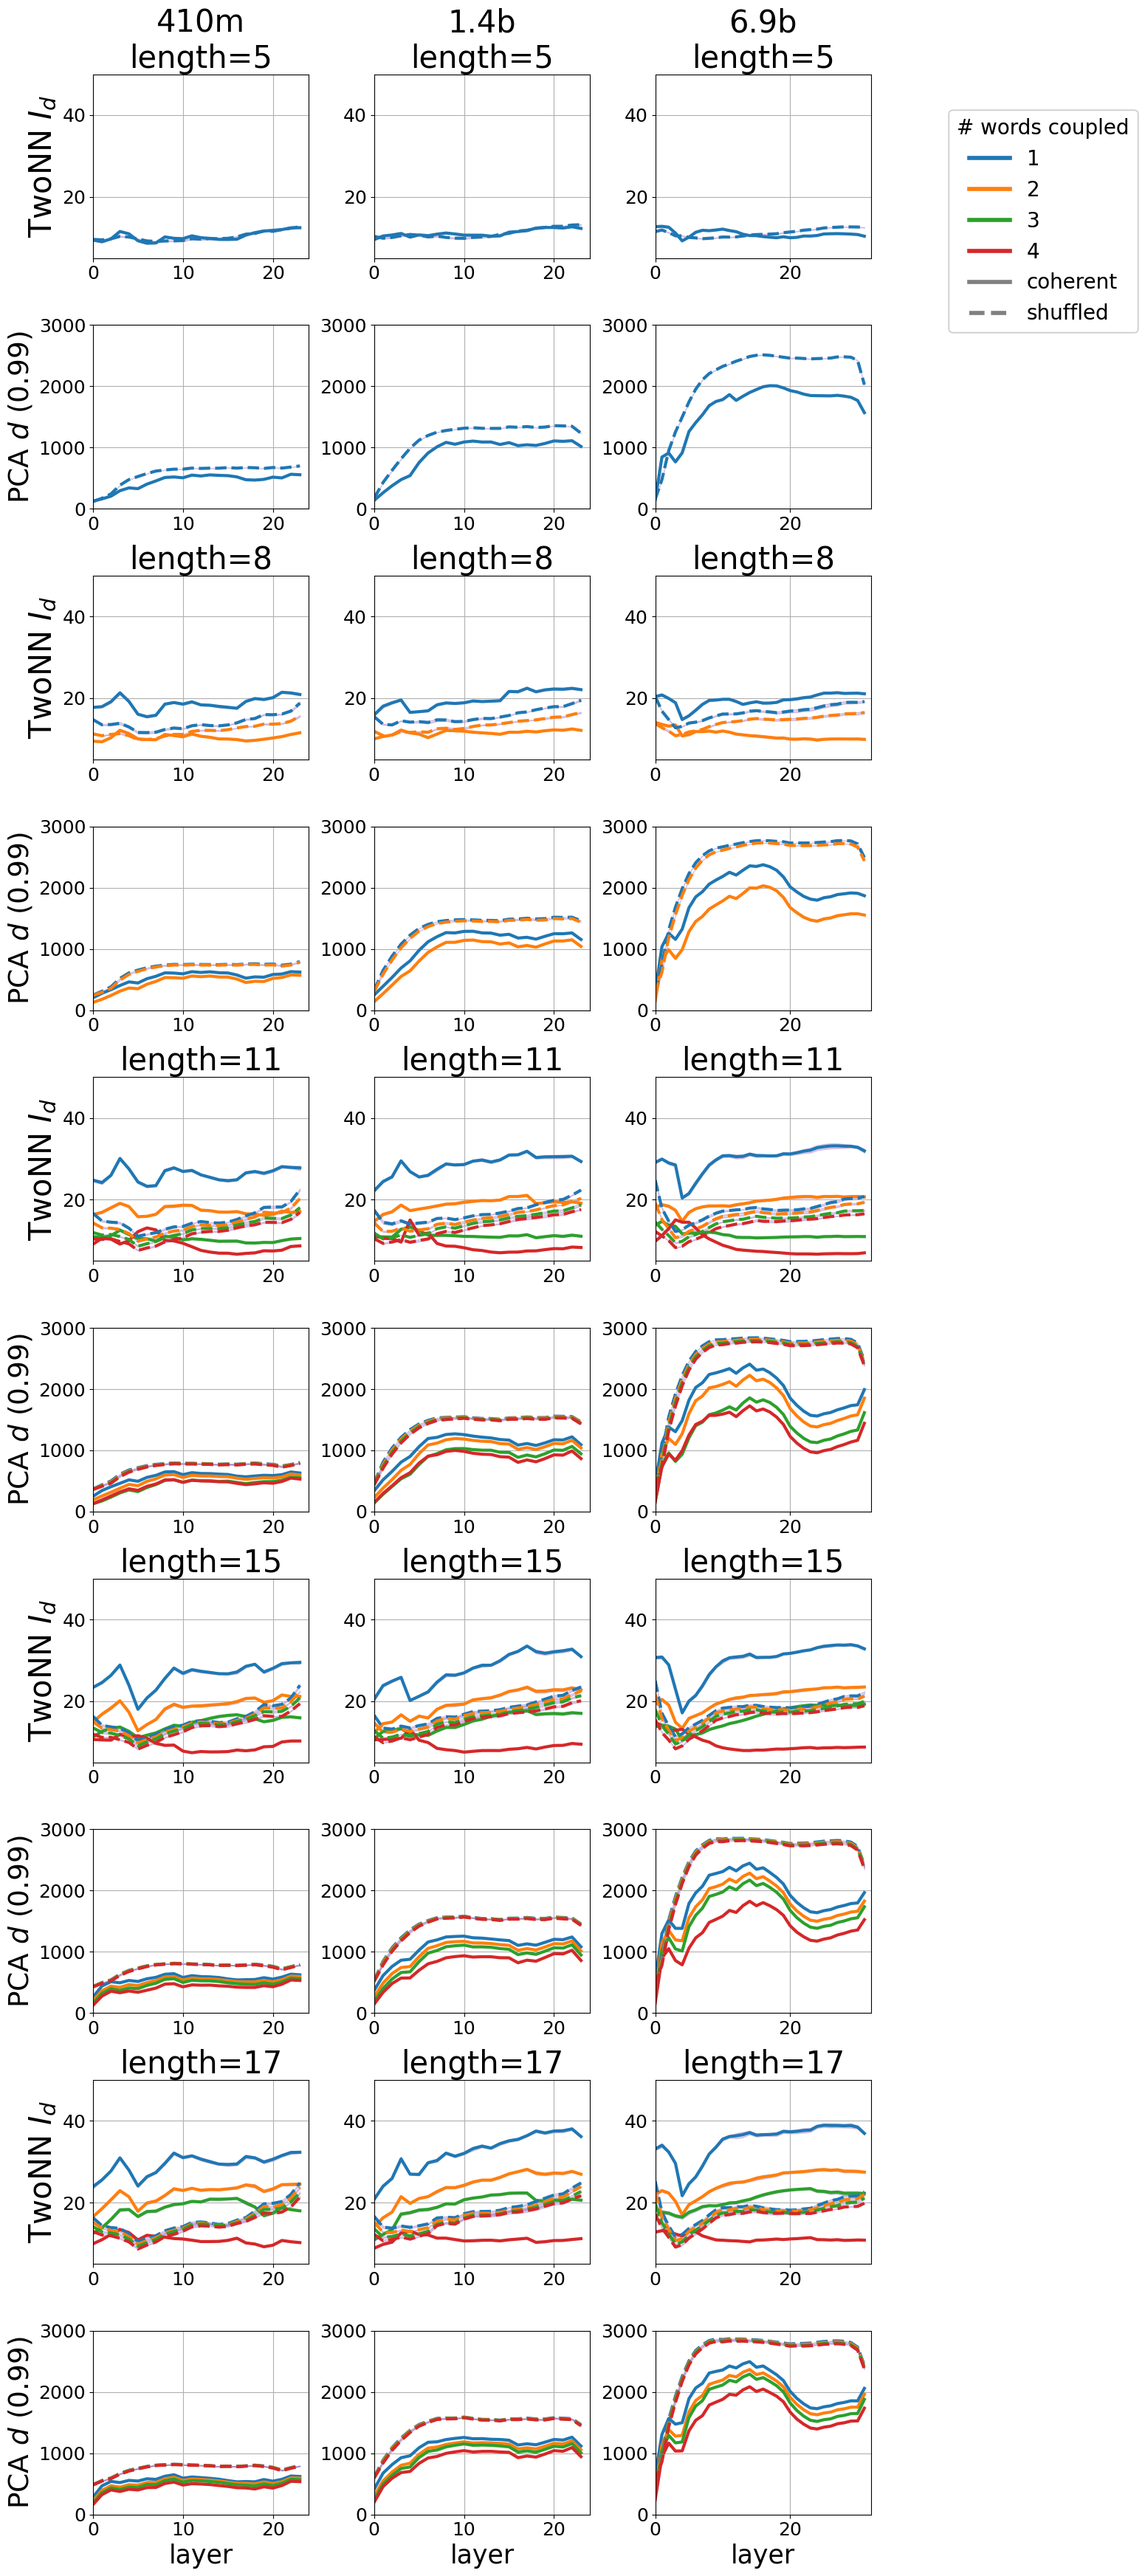

In [46]:
sizes = SCALING_SIZES
lengths = [5, 8, 11, 15, 17]

fig, axs = plt.subplots(10, len(sizes), figsize=(4 * len(sizes), 7 * 5))

for m, l in enumerate(lengths):
    block = m
    for i, method in enumerate(['twonn', 'pca']):
        row = 2 * block + i
        for j, model in enumerate(sizes):

            # plot over layers
            ax = axs[row][j]

            # first get the x and y and std for sane
            model_df = results_df[(results_df['model']==model) & (results_df['step']==143000) & (results_df['length']==l)]

            for mode in ['sane', 'shuffled']:
                setting_df = model_df[model_df['mode'] == mode]

                for k, ds in enumerate([1, 2, 3, 4]):
                    if l == 5 and ds > 1: continue
                    if l == 8 and ds > 2: continue
                    df = setting_df[(setting_df['words_coupled']== str(ds)) | (setting_df['words_coupled']== ds)]

                    ax.plot(
                        df['layer'], 
                        df[f'{method}_mean'], 
                        color=DATASET_COLORS[k], 
                        marker=None,#'o' if mode == 'sane' else '^',
                        linestyle='--' if mode == 'shuffled' else None,
                        linewidth=3,
                        # markersize=6
                    )
                    ax.fill_between(df['layer'], 
                        df[f'{method}_mean'] - df[f'{method}_std'],
                        df[f'{method}_mean'] + df[f'{method}_std'],
                        alpha=0.3,
                        color=DATASET_COLORS[4]
                                   )
            ax.set_xlim([0, len(df['layer'])])
            
            if i == 0:
                ax.set_ylim([5, 50])
            else:
                ax.set_ylim([0, 3000])
            if row == 0:
                ax.set_title(model + f'\nlength={l}', fontsize=30)
            elif row % 2 == 0:
                ax.set_title(f'length={l}', fontsize=30)
            ax.grid(True)
            # ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
            ax.tick_params(axis='x', labelsize=18)
            ax.tick_params(axis='y', labelsize=18)
            if row == 9:
                ax.set_xlabel('layer', fontsize=25)
    
            if j == 0:
                if i == 0:
                    ax.set_ylabel(r'TwoNN $I_d$', fontsize=30)
                else:
                    ax.set_ylabel(r'PCA $d$ (0.99)', fontsize=27)


            # Custom legend handles for both subplots
            if l == 5:
                custom_lines = [Line2D([0], [0], color=color, marker=None, lw=4) for color in DATASET_COLORS[:-1]] + \
                    [Line2D([0], [0], color='gray', lw=4), Line2D([0], [0], color='gray', linestyle='--', lw=4)]
        
                fig.legend(custom_lines, 
                   [1, 2, 3, 4, 'coherent', 'shuffled'], 
                   ncol=1, title='# words coupled', bbox_to_anchor=(1.3, 0.96), fontsize=20, title_fontsize=20)

            
fig.tight_layout()
# fig.show()



for ext in ['svg', 'png', 'pdf']:
    fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/other_lengths_nonlinear_linear_id_app.{ext}', bbox_inches='tight')

## ID scaling wrt length

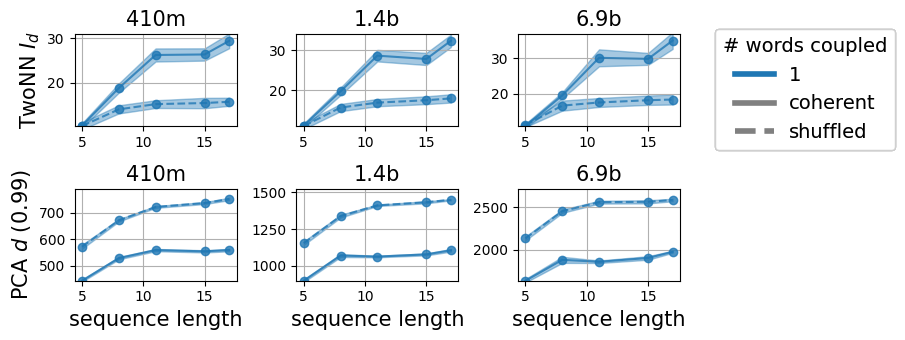

In [48]:
# Make figure
Ls = lengths #[HIDDEN_DIMS[model] for model in HIDDEN_DIMS]
m1 = 'twonn'
m2 = 'pca'

fig, axs = plt.subplots(2, 3, figsize=(7, 3.5))

for n, model in enumerate(SCALING_SIZES):
    model_df = results_df[results_df['model']==model]

    for ds in [1]:#, 2, 3, 4]:
        for j, method in enumerate([m1, m2]):

            min_, max_ = np.infty, 0

            for i, mode in enumerate(MODES):
                last_ckpt_df = model_df[
                    (model_df['step']==143000) & (model_df['words_coupled']==ds) & (model_df['mode']==mode)
                ]
        
                # Mean
                agg_std = lambda x: np.sqrt(np.sum([x_**2 for x_ in x]))
                last_ckpt_mean = last_ckpt_df[['length', f'{m1}_mean', f'{m2}_mean']]
                last_ckpt_std = last_ckpt_df[['length', f'{m1}_std', f'{m2}_std']]
                means_df = last_ckpt_mean.groupby('length').agg(['mean'])
                std_df = last_ckpt_std.groupby('length').agg([agg_std])
                means_df = means_df.merge(std_df, on='length')
                means_df = means_df.reset_index()

                # Plot one line per datas
                ys = np.array([means_df[means_df['length']==l][(f'{method}_mean','mean')] for l in means_df['length'].unique()])[:,0]
                if min(ys) < min_: min_ = min(ys)
                if max(ys) > max_: max_ = max(ys)
                    
                ystd = np.array([means_df[means_df['length']==l][(f'{method}_std','<lambda>')] for l in means_df['length'].unique()])[:,0]
                ax = axs[j][n]
                
                ax.plot(
                    means_df['length'], 
                    ys, 
                    label=f'{l}',
                    linestyle='--' if mode == 'shuffled' else None,
                    marker='o',
                    alpha=0.8,
                    color=DATASET_COLORS[ds-1]
                )
                ax.fill_between(means_df['length'], ys - ystd, ys + ystd, alpha=0.4, color=DATASET_COLORS[ds-1])
                
            ax.set_title(model, fontsize=15)
            ax.grid(True)

                
            if method == 'twonn' and n == 0:
                ax.set_ylabel(r'TwoNN $I_d$', fontsize=15)
            elif n == 0:
                ax.set_ylabel(r'PCA $d$ (0.99)', fontsize=15)

            if j == 1: ax.set_xlabel(r'sequence length', fontsize=15)
            # if j == 0:
                # ax.set_ylim([8, 40])
            # else:
            ax.set_ylim([min_, 1.05*max_])
                
                # axs[j].set_yticklabels(axs[j].get_yticklabels(), fontsize=10)
                # axs[j].set_xticklabels(axs[j].get_xticklabels(), fontsize=10)
    
            # Custom legend handles for both subplots
            custom_lines = [Line2D([0], [0], color=DATASET_COLORS[0], lw=4), Line2D([0], [0], color='gray', lw=4), Line2D([0], [0], color='gray', linestyle='--', lw=4)]
            
            fig.legend(custom_lines, 
                       [1, 'coherent', 'shuffled'], 
                       ncol=1, title='# words coupled', bbox_to_anchor=(1.3, 0.93), fontsize=14, title_fontsize=14)
fig.tight_layout()
# fig.show()

for ext in ['svg', 'png', 'pdf']:
    fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/scaling_sequence_length_appendix.{ext}', bbox_inches='tight')

# KC plots

In [33]:
import random

In [34]:
def create_shuffled_version(fpath, savepath):
    with open(fpath, 'r') as f:
        data = f.readlines()

    for i in range(len(data)):
        data[i] = data[i].split(" ")
        random.shuffle(data[i])
        data[i] = " ".join(data[i])

    with open(savepath, 'w') as f:
        f.writelines(data)

In [158]:
f_format = '/home/echeng/llm_compositionality/train_test_splits_lengths/train_prompts_length_{}_{}_words_correlated_rs0.txt'
save_format = '/home/echeng/llm_compositionality/train_test_splits_lengths/train_prompts_length_{}_{}_words_correlated_shuffled_rs0.txt'

for l in [3, 6, 9, 11, 13]:
    for k in [1, 2, 3, 4]:
        if l == 3 and k > 1: continue
        if l == 6 and k > 2: continue
        fpath = f_format.format(l, k)
        savepath = save_format.format(l, k)
        create_shuffled_version(fpath, savepath)

## Global correlation across sequence length for single model

In [30]:
from scipy.stats import pearsonr, spearmanr

In [39]:
results_df[results_df['model']=='14m']

,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer,length
0,53.4,0.489898,10.023844,0.139006,16.506662,0.210626,15.870417,0.066525,sane,1,143000.0,128,14m,0,17
1,48.8,0.400000,2.332995,0.021067,16.656263,0.201438,15.666395,0.060086,sane,1,143000.0,128,14m,1,17
2,15.8,0.400000,1.148035,0.002858,14.361790,0.162540,12.535373,0.079673,sane,1,143000.0,128,14m,2,17
3,58.6,0.489898,2.288972,0.020985,19.096650,0.118006,18.566925,0.076999,sane,1,143000.0,128,14m,3,17
4,85.6,0.489898,7.463161,0.174198,22.691318,0.112240,21.408925,0.071060,sane,1,143000.0,128,14m,4,17
5,90.0,0.000000,27.937566,0.199841,21.071444,0.422455,20.904152,0.074064,sane,1,143000.0,128,14m,5,17
6,108.0,0.000000,13.485658,0.160106,10.201885,0.119502,5.207724,0.028860,shuffled,1,143000.0,128,14m,0,17
7,106.0,0.000000,11.165638,0.083326,9.048636,0.094729,5.376523,0.034427,shuffled,1,143000.0,128,14m,1,17
8,74.4,0.800000,2.432961,0.085655,7.955272,0.130134,8.913651,0.033886,shuffled,1,143000.0,128,14m,2,17
9,97.8,0.400000,4.489775,0.251764,10.999761,0.035352,9.516263,0.052426,shuffled,1,143000.0,128,14m,3,17


In [32]:
for model in list(HIDDEN_DIMS.keys()):
    model_df = new_df[new_df['model']==model]
    global_stats = model_df[['gzip', 'pca_mean', 'twonn_mean']].groupby('gzip').mean().reset_index()
    print(model)
    print(spearmanr(global_stats['gzip'], global_stats['pca_mean']))

14m
SignificanceResult(statistic=0.023657077710190984, pvalue=0.9012468473437181)
70m
SignificanceResult(statistic=0.957285873192436, pvalue=1.2685049691700102e-16)
160m
SignificanceResult(statistic=-0.23203559510567295, pvalue=0.21726531664492563)
410m
SignificanceResult(statistic=0.784824046920821, pvalue=1.0537020175656408e-07)
1.4b
SignificanceResult(statistic=0.7331378299120234, pvalue=1.8211882810470529e-06)
6.9b
SignificanceResult(statistic=0.846041055718475, pvalue=1.076025243642671e-09)
12b
SignificanceResult(statistic=0.8705228031145716, pvalue=4.0585857280067005e-10)
llama
SignificanceResult(statistic=0.8096810225362563, pvalue=1.999094249313452e-08)
mistral
SignificanceResult(statistic=0.7752109065406004, pvalue=1.8928086954178786e-07)


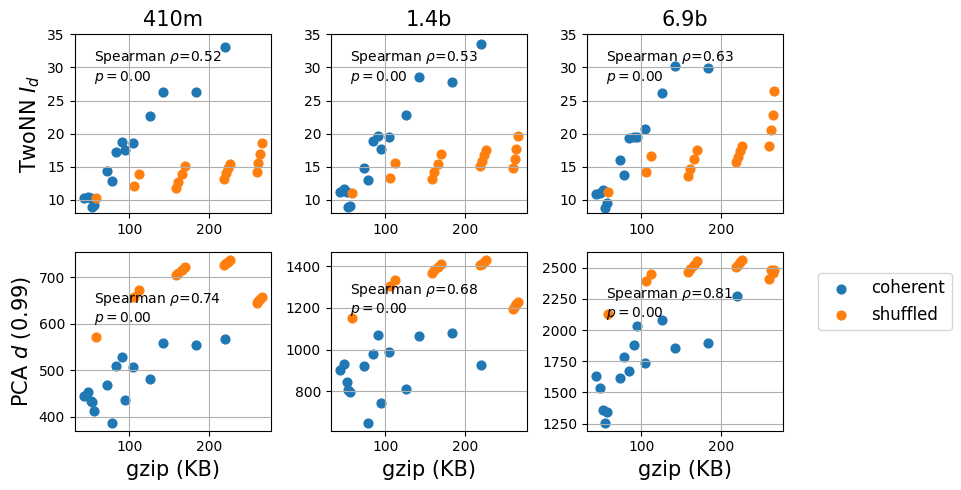

In [259]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

for i, model in enumerate(SCALING_SIZES):
    model_df = new_df[(new_df['model']==model) & (new_df['words_coupled']!='pile')]
    global_stats = model_df[['gzip', 'pca_mean', 'twonn_mean']].groupby('gzip').mean().reset_index()
    sane_stats = model_df[model_df['mode'] == 'sane'][['gzip', 'pca_mean', 'twonn_mean']].groupby('gzip').mean().reset_index()
    shuff_stats = model_df[model_df['mode'] == 'shuffled'][['gzip', 'pca_mean', 'twonn_mean']].groupby('gzip').mean().reset_index()
        
    for j, method in enumerate(['twonn', 'pca']):
        ax = axs[j][i]
        ax.scatter(sane_stats['gzip'], sane_stats[f'{method}_mean'], label='coherent', s=40)
        ax.scatter(shuff_stats['gzip'], shuff_stats[f'{method}_mean'], label='shuffled', s=40)

        # Correlate
        r, p = spearmanr(global_stats['gzip'], global_stats[f'{method}_mean'])
        
        if j == 1:
            ax.set_xlabel('gzip (KB)', fontsize=15)
            # ax.set_ylim([-100, 3000])
        if i == 0:
            ylab = r'TwoNN $I_d$' if method == 'twonn' else r'PCA $d$ (0.99)'
            ax.set_ylabel(ylab, fontsize=15) 
        if j == 0:
            ax.set_title(model, fontsize=15)
            ax.set_ylim([8, 35])
        
        x, y = ax.get_xlim()[1] * 0.2 , ax.get_ylim()[1] * 0.8
        ax.text(x, y, r'Spearman $\rho$=' + f'{r:.2f}\n' + r'$p=$' + f'{p:.2f}')
        
        ax.grid()
        
ax.legend(fontsize=12, bbox_to_anchor=(1.9, 0.93))
fig.tight_layout()


# for ext in ['svg', 'png', 'pdf']:
    # fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/kc_all_settings_appendix.{ext}', bbox_inches='tight')

## For each model, sequence length, correlate mean dim vs gzip

In [45]:
for i, model in enumerate(list(HIDDEN_DIMS.keys())):
    for l in LENGTHS + [17]:
        model_df = new_df[(new_df['model']==model) & (new_df['words_coupled']!='pile') & (new_df['length'] == l)]
        global_stats = model_df[['gzip', 'pca_mean', 'twonn_mean']].groupby('gzip').mean().reset_index()

        for j, method in enumerate(['twonn', 'pca']):
            # Correlate
            r, p = spearmanr(global_stats['gzip'], global_stats[f'{method}_mean'])

            print(f'model: {model}, length: {l}, method: {method}, R: {r:.2f}, p: {p:.3f}')

model: 14m, length: 3, method: twonn, R: 1.00, p: nan
model: 14m, length: 3, method: pca, R: 1.00, p: nan
model: 14m, length: 6, method: twonn, R: 0.89, p: 0.106
model: 14m, length: 6, method: pca, R: 0.89, p: 0.106
model: 14m, length: 9, method: twonn, R: 0.87, p: 0.005
model: 14m, length: 9, method: pca, R: 0.87, p: 0.005
model: 14m, length: 11, method: twonn, R: 0.87, p: 0.005
model: 14m, length: 11, method: pca, R: 0.87, p: 0.005
model: 14m, length: 17, method: twonn, R: -0.10, p: 0.823
model: 14m, length: 17, method: pca, R: 0.81, p: 0.015
model: 70m, length: 3, method: twonn, R: 1.00, p: nan
model: 70m, length: 3, method: pca, R: 1.00, p: nan
model: 70m, length: 6, method: twonn, R: 0.40, p: 0.600
model: 70m, length: 6, method: pca, R: 1.00, p: 0.000
model: 70m, length: 9, method: twonn, R: 0.43, p: 0.289
model: 70m, length: 9, method: pca, R: 1.00, p: 0.000
model: 70m, length: 11, method: twonn, R: 0.26, p: 0.531
model: 70m, length: 11, method: pca, R: 0.98, p: 0.000
model: 70m,

In [277]:
new_df

,pca_mean,pca_std,pr_mean,pr_std,twonn_mean,twonn_std,mle_mean,mle_std,mode,words_coupled,step,D,model,layer,length,gzip
0,53.4,0.489898,10.023844,0.139006,16.506662,0.210626,15.870417,0.066525,sane,1,143000,128,14m,0,17,220.036133
1,48.8,0.400000,2.332995,0.021067,16.656263,0.201438,15.666395,0.060086,sane,1,143000,128,14m,1,17,220.036133
2,15.8,0.400000,1.148035,0.002858,14.361790,0.162540,12.535373,0.079673,sane,1,143000,128,14m,2,17,220.036133
3,58.6,0.489898,2.288972,0.020985,19.096650,0.118006,18.566925,0.076999,sane,1,143000,128,14m,3,17,220.036133
4,85.6,0.489898,7.463161,0.174198,22.691318,0.112240,21.408925,0.071060,sane,1,143000,128,14m,4,17,220.036133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29291,2763.6,1.959592,26.033204,0.300228,18.068401,0.107697,16.416395,0.104495,shuffled,4,143000,4096,6.9b,27,11,218.746094
29292,2754.6,1.959592,25.628805,0.263835,18.399898,0.127881,16.909434,0.109922,shuffled,4,143000,4096,6.9b,28,11,218.746094
29293,2734.6,1.743560,24.408060,0.236526,18.485105,0.129952,17.120263,0.095940,shuffled,4,143000,4096,6.9b,29,11,218.746094
29294,2660.0,2.097618,19.407399,0.194983,18.449557,0.112230,17.383421,0.090073,shuffled,4,143000,4096,6.9b,30,11,218.746094


# Summary plot of layerwise correlations to gzip, KC

In [15]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np

       pca_mean   pca_std    pr_mean    pr_std  twonn_mean  twonn_std  \
0          53.4  0.489898  10.023844  0.139006   16.506662   0.210626   
1          48.8  0.400000   2.332995  0.021067   16.656263   0.201438   
2          15.8  0.400000   1.148035  0.002858   14.361790   0.162540   
3          58.6  0.489898   2.288972  0.020985   19.096650   0.118006   
4          85.6  0.489898   7.463161  0.174198   22.691318   0.112240   
...         ...       ...        ...       ...         ...        ...   
28683    3282.2  2.039608  21.206685  0.210419   18.240448   0.179843   
28684    3274.4  1.959592  21.544633  0.179944   18.397405   0.191968   
28685    3236.0  1.673320  19.870084  0.150469   18.407868   0.194845   
28686    3159.6  1.959592  17.242026  0.148424   18.324540   0.175687   
28687    2866.8  9.130170  19.767490  0.772265   18.975086   0.128280   

        mle_mean   mle_std      mode words_coupled    step    D model  layer  \
0      15.870417  0.066525      sane       

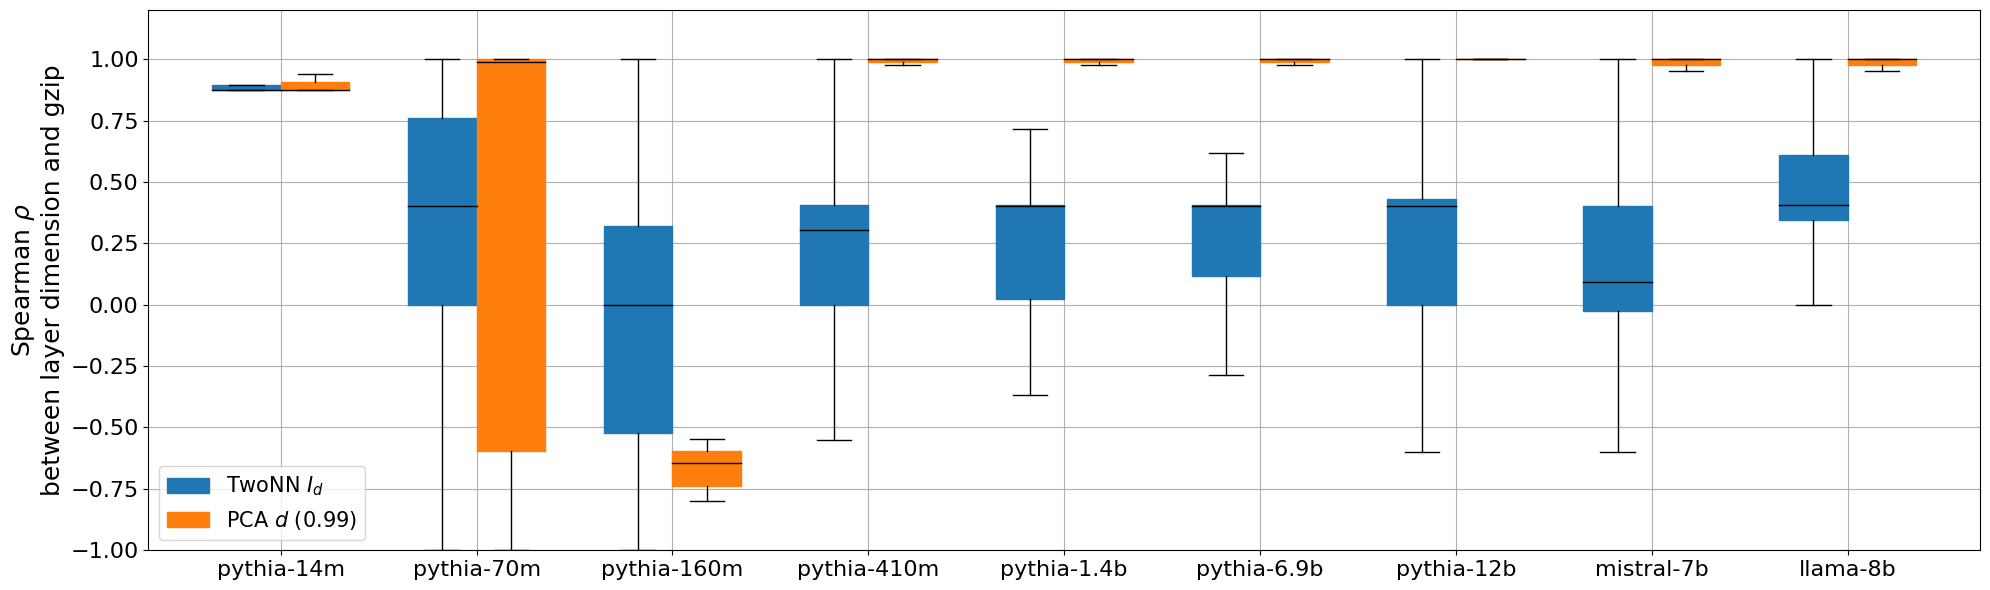

In [44]:
# Sample data
models = list(HIDDEN_DIMS.keys())

def correlate_gzip_dim_for_layers(model, method):
    if model not in ('mistral', 'llama'):
        model_df = new_df[(new_df['model']==model) & (new_df['step']==143000)]
    else:
        model_df = new_df[new_df['model']==model]
    if model == '14m':
        print(model_df)
    corrs = []
    for layer in model_df['layer'].unique():
        for l in model_df['length'].unique():
            layer_df = model_df[(model_df['layer']==layer) & (model_df['length']==l)]
            stats = layer_df[['gzip', f'{method}_mean']].groupby('gzip').mean().reset_index()
            r, _ = spearmanr(stats['gzip'], stats[f'{method}_mean'])
            if np.isnan(r): continue
            corrs.append(r)
    return corrs
        

# Colors for R_1 and R_2
colors = {r'TwoNN $I_d$': DATASET_COLORS[0], r'PCA $d$ (0.99)': DATASET_COLORS[1]}

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Set y-axis limits
ax.set_ylim(-1, 1.2)

# Boxplot settings
boxplot_width = 0.35  # Width of each boxplot
positions_R1 = [i - boxplot_width/2 for i in range(len(models))]  # Positions for R_1 boxplots
positions_R2 = [i + boxplot_width/2 for i in range(len(models))]  # Positions for R_2 boxplots

ID_corrs = [correlate_gzip_dim_for_layers(model, 'twonn') for model in models]
d_corrs = [correlate_gzip_dim_for_layers(model, 'pca') for model in models]

# Plot R_1 and R_2 as boxplots
ax.boxplot(ID_corrs, positions=positions_R1, widths=boxplot_width, patch_artist=True, 
       boxprops=dict(facecolor=DATASET_COLORS[0], color=DATASET_COLORS[0]),
       medianprops=dict(color='black'), showfliers=False, labels=[None]*len(models))

ax.boxplot(d_corrs, positions=positions_R2, widths=boxplot_width, patch_artist=True, 
       boxprops=dict(facecolor=DATASET_COLORS[1], color=DATASET_COLORS[1]),
       medianprops=dict(color='black'), showfliers=False, labels=[None]*len(models))


    # # R_1 stripplot
    # ax.boxplot(np.array([i - 0.15] * len(ID_corr)), ID_corr, color=colors[r'TwoNN $I_d$'], label=r'TwoNN $I_d$' if i == 0 else "")
    
    # # R_2 stripplot
    # ax.scatter(np.array([i + 0.15] * len(d_corr)), d_corr, color=colors[r'PCA $d$ (0.99)'], label=r'PCA $d$ (0.99)' if i == 0 else "")

# Customizing plot
ax.set_xticks(range(len(models)))
ax.set_xticklabels([f'pythia-{m}' for m in list(HIDDEN_DIMS.keys())[:-2]] + ['mistral-7b', 'llama-8b'])
ax.grid()
ax.set_ylabel(r"Spearman $\rho$" + '\nbetween layer dimension and gzip', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
# Create legend with patches
legend_patches = [Patch(color=DATASET_COLORS[0], label=r'TwoNN $I_d$'),
                  Patch(color=DATASET_COLORS[1], label=r'PCA $d$ (0.99)')]
ax.legend(handles=legend_patches, fontsize=15)

fig.tight_layout()
for ext in ['png', 'pdf', 'svg']:
    fig.savefig(f'/home/echeng/llm_compositionality/results/plots/neurips_plots/kc_summary_all_models_all_lengths.{ext}')